In [2]:
import cvxpy as cvx
import numpy as np

import matplotlib.pyplot as plt
from scipy import signal
import random
from scipy.stats import laplace_asymmetric
from sklearn.metrics import mean_absolute_error as mae

from utils import plot_decomp, plot_signal

from gfosd import Problem
from gfosd.components import *

np.random.seed(12) 
random.seed(10)

## `tl1_l2d2p365`

### Create input signal

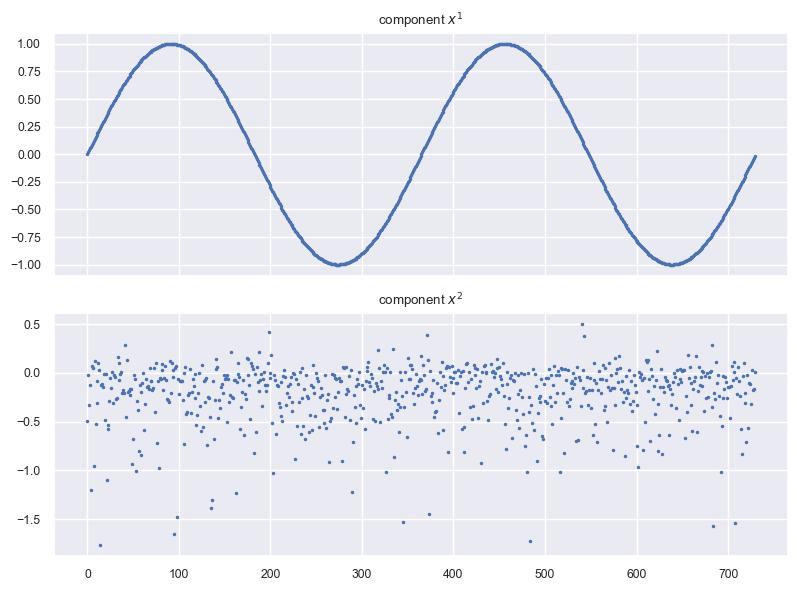

In [3]:
t = np.arange(365*2)

# seasonal periodic
signal1 = np.sin(2 * np.pi * t * 1 / (365.))
# asymmetric laplacian noise
kappa = 2 # k>0, k=1 is laplace
signal2 = 0.15 * laplace_asymmetric.rvs(kappa, size=len(signal1))

X_real = np.zeros((2, len(t)), dtype=float)
X_real[0] = signal1
X_real[1] = signal2

y = np.sum(X_real, axis=0)
plot_decomp(X_real)

In [4]:
np.quantile(signal2, 0.8) 

0.006092775222533824

### CVXPY + MOSEK function

In [10]:
def tl1_l2d2p365( # called 7 times
    signal,
    use_ixs=None,
    tau=0.8, # passed as 0.05 (sunrise), 0.95 (sunset), 0.9, 0.85
    w2=1e3,  # default not overwritten in calls, or same val passed
    solver="MOSEK",
    yearly_periodic=True, # passed as False twice
    verbose=False,
    s_seas_osd=None # for calculating OSD equivalent objective
):
    if use_ixs is None:
        use_ixs = ~np.isnan(signal)
    x = cvx.Variable(len(signal))
    r = signal[use_ixs] - x[use_ixs]
    
    objective = cvx.Minimize(
        cvx.sum(0.5 * cvx.abs(r) + (tau - 0.5) * r) + w2 * cvx.norm(cvx.diff(x, k=2))
    )
    
    if len(signal) > 365 and yearly_periodic:
        constraints = [x[365:] == x[:-365]]
    else:
        constraints = []
        
    problem = cvx.Problem(objective, constraints=constraints)
    
    problem.solve(solver=solver, verbose=verbose)

    if s_seas_osd is not None:
        print(f"CVXPY objective       {problem.objective.value:.5f}")
        x.value = s_seas_osd
        print(f"OSD objective, scaled {problem.objective.value:.5f}")
        return problem.objective.value
    
    return x.value,  problem.objective.value

### OSD + MOSEK function

In [24]:
def gfosd_tl1_l2d2p365(
        signal,
        tau=0.8,
        w1=1,
        w2=1e3,
        yearly_periodic=True, 
        verbose=False,
        solver="MOSEK"
):
    '''
    - tl1: tilted laplacian noise
    - l2d2p365: small second order diffs (smooth) and 365-periodic
    '''

    c1 = SumQuantile(tau=tau, weight=w1)
    c2 = SumSquare(weight=w2, diff=2)
    
    if len(signal) > 365 and yearly_periodic:
        c2 = Aggregate([c2, Periodic(365)])

    classes = [c1, c2]
    
    problem = Problem(signal, classes)
    
    problem.decompose(solver=solver, verbose=verbose)
    s_error =  problem.decomposition[0]
    s_seas = problem.decomposition[1]

    return s_seas, s_error, problem.objective_value

### Run with default weights (w2=1000)

CVXPY objective       49.02457
OSD objective, scaled 67.19762
s_hat MAE (OSD,CVX)   1.80e-02


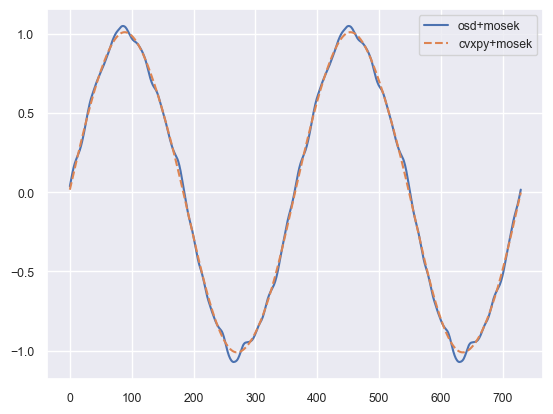

In [14]:
x_cvxpy_mosek, obj_cvxpy_mosek = tl1_l2d2p365(y)
x_osd_mosek, err_osd_mosek, obj_osd_mosek = gfosd_tl1_l2d2p365(y)

obj_osd_scaled = tl1_l2d2p365(y, s_seas_osd=x_osd_mosek) 
print(f's_hat MAE (OSD,CVX)   {mae(x_osd_mosek, x_cvxpy_mosek):.2e}')

plt.plot(x_osd_mosek, label="osd+mosek")
plt.plot(x_cvxpy_mosek, linestyle="--", label="cvxpy+mosek")
plt.legend();

### Run w/ CVXPY with default weights, OSD with hand-tuned weights (w1=0.001, w2=220)

CVXPY objective       49.02457
OSD objective, scaled 49.02898
s_hat MAE (OSD,CVX)   1.15e-03


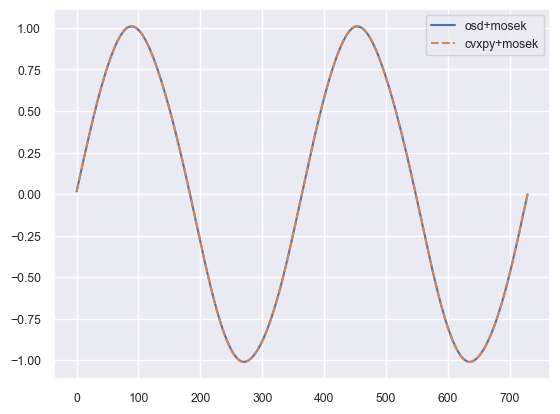

In [22]:
x_cvxpy_mosek, obj_cvxpy_mosek = tl1_l2d2p365(y)
x_osd_mosek, err_osd_mosek, obj_osd_mosek = gfosd_tl1_l2d2p365(y, w1=0.001, w2=220)

obj_osd_scaled = tl1_l2d2p365(y, s_seas_osd=x_osd_mosek) 
print(f's_hat MAE (OSD,CVX)   {mae(x_osd_mosek, x_cvxpy_mosek):.2e}')

plt.plot(x_osd_mosek, label="osd+mosek")
plt.plot(x_cvxpy_mosek, linestyle="--", label="cvxpy+mosek")
plt.legend();

### Run w/ CVXPY with default weights, OSD with other hand-tuned weights (w1=0.007, w2=1000)

CVXPY objective       49.02457
OSD objective, scaled 49.02717
s_hat MAE (OSD,CVX)   1.41e-03


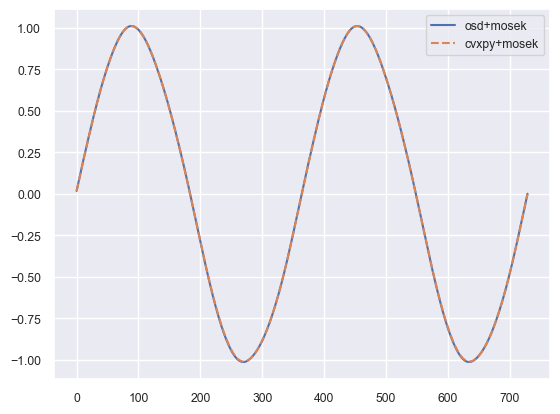

In [23]:
x_cvxpy_mosek, obj_cvxpy_mosek = tl1_l2d2p365(y)
x_osd_mosek, err_osd_mosek, obj_osd_mosek = gfosd_tl1_l2d2p365(y, w1=0.007, w2=1000)

obj_osd_scaled = tl1_l2d2p365(y, s_seas_osd=x_osd_mosek) 
print(f's_hat MAE (OSD,CVX)   {mae(x_osd_mosek, x_cvxpy_mosek):.2e}')

plt.plot(x_osd_mosek, label="osd+mosek")
plt.plot(x_cvxpy_mosek, linestyle="--", label="cvxpy+mosek")
plt.legend();

### Run w/ QSS with default weights

CVXPY objective       49.02457
OSD objective, scaled 67.19801
s_hat MAE (OSD,CVX)   1.80e-02


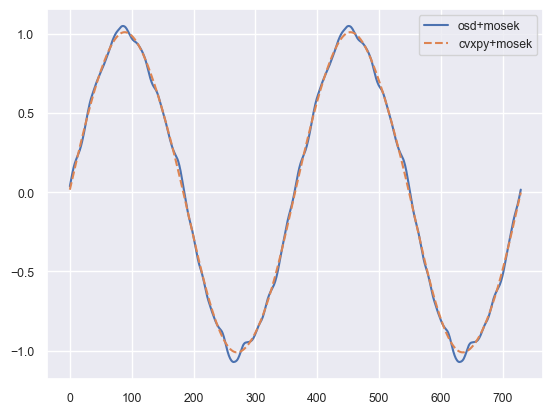

In [27]:
x_cvxpy_mosek, obj_cvxpy_mosek = tl1_l2d2p365(y)
x_osd_mosek, err_osd_mosek, obj_osd_mosek = gfosd_tl1_l2d2p365(y, solver="QSS")

obj_osd_scaled = tl1_l2d2p365(y, s_seas_osd=x_osd_mosek) 
print(f's_hat MAE (OSD,CVX)   {mae(x_osd_mosek, x_cvxpy_mosek):.2e}')

plt.plot(x_osd_mosek, label="osd+mosek")
plt.plot(x_cvxpy_mosek, linestyle="--", label="cvxpy+mosek")
plt.legend();

### Run w/ QSS with adjusted weights (w1=0.007, w2=1000)

CVXPY objective       49.02457
OSD objective, scaled 49.02716
s_hat MAE (OSD,CVX)   1.39e-03


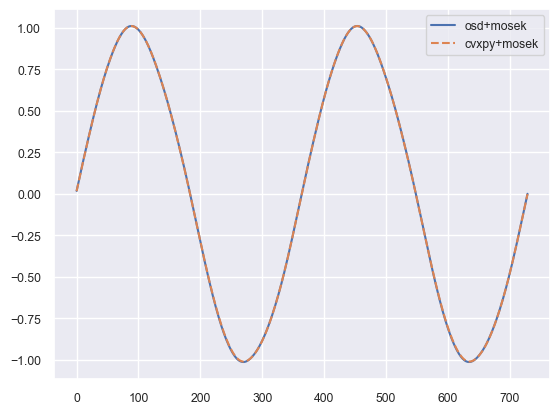

In [28]:
x_cvxpy_mosek, obj_cvxpy_mosek = tl1_l2d2p365(y)
x_osd_mosek, err_osd_mosek, obj_osd_mosek = gfosd_tl1_l2d2p365(y, solver="QSS", w1=0.007, w2=1000)

obj_osd_scaled = tl1_l2d2p365(y, s_seas_osd=x_osd_mosek) 
print(f's_hat MAE (OSD,CVX)   {mae(x_osd_mosek, x_cvxpy_mosek):.2e}')

plt.plot(x_osd_mosek, label="osd+mosek")
plt.plot(x_cvxpy_mosek, linestyle="--", label="cvxpy+mosek")
plt.legend();